# Loads packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.optim as optim
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import sys,os
sys.path.append(os.path.realpath('./src/'))
import pandas as pd
from materialEncoder import MaterialEncoder
import time
import itertools

# Defines functions

In [2]:
def to_np(x):
  return x.detach().cpu().numpy()

def to_torch(x):
  return torch.tensor(x).float()

# Loads the Database

In [3]:
def preprocessData():
  df = pd.read_excel('./data/MaterialDatabase_FULL.xlsx')# # 
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = np.log10(df[df.columns[3:]].to_numpy())
  dataScaleMax = torch.tensor(np.max(trainInfo, axis = 0))
  dataScaleMin = torch.tensor(np.min(trainInfo, axis = 0))
  normalizedData = (torch.tensor(trainInfo) - dataScaleMin)/(dataScaleMax - dataScaleMin)
  trainingData = torch.tensor(normalizedData).float()
  dataInfo = {'youngsModulus':{'idx':0,'scaleMin':dataScaleMin[0], 'scaleMax':dataScaleMax[0]},\
              'costPerKg':{'idx':1,'scaleMin':dataScaleMin[1], 'scaleMax':dataScaleMax[1]},\
              'massDensity':{'idx':2,'scaleMin':dataScaleMin[2], 'scaleMax':dataScaleMax[2]},\
              'yieldStrength':{'idx':3,'scaleMin':dataScaleMin[3], 'scaleMax':dataScaleMax[3]},\
              'co2Kg':{'idx':4,'scaleMin':dataScaleMin[4], 'scaleMax':dataScaleMax[4]},\
              'energyKg':{'idx':5,'scaleMin':dataScaleMin[5], 'scaleMax':dataScaleMax[5]},\
              'waterKg':{'idx':6,'scaleMin':dataScaleMin[6], 'scaleMax':dataScaleMax[6]}}

  return trainingData, dataInfo, dataIdentifier, trainInfo, df
trainingData, dataInfo, dataIdentifier, trainInfo, df = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape
props = df.columns[3:].tolist()

C:\Users\luisy\AppData\Local\Temp\ipykernel_14308\405064810.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainingData = torch.tensor(normalizedData).float()


# Trains the VAE

In [4]:
latentDim, hiddenDim = 2, 250
numEpochs = 50000
epsilon=4.2e-2
epsilon=2e-2
numEpochs = 50000
klFactor = 5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}

materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)

start = time.perf_counter()
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate, epsilon)
print('training time : {:.2F} '.format(time.perf_counter() - start))

Iter 0 reconLoss 4.68E+01 klLoss 5.67E-03 loss 4.68E+01
Iter 500 reconLoss 2.33E-01 klLoss 6.02E-02 loss 2.93E-01
Iter 1000 reconLoss 1.08E-01 klLoss 5.91E-02 loss 1.67E-01
Iter 1500 reconLoss 7.33E-02 klLoss 5.82E-02 loss 1.32E-01
Iter 2000 reconLoss 6.02E-02 klLoss 5.65E-02 loss 1.17E-01
Iter 2500 reconLoss 4.35E-02 klLoss 5.46E-02 loss 9.81E-02
Iter 3000 reconLoss 4.59E-02 klLoss 5.28E-02 loss 9.87E-02
Iter 3500 reconLoss 3.41E-02 klLoss 5.15E-02 loss 8.56E-02
Iter 4000 reconLoss 3.73E-02 klLoss 5.02E-02 loss 8.75E-02
Iter 4500 reconLoss 3.03E-02 klLoss 4.89E-02 loss 7.91E-02
Iter 5000 reconLoss 2.83E-02 klLoss 4.79E-02 loss 7.62E-02
Iter 5500 reconLoss 2.79E-02 klLoss 4.69E-02 loss 7.48E-02
Iter 6000 reconLoss 3.14E-02 klLoss 4.57E-02 loss 7.71E-02
Iter 6500 reconLoss 2.66E-02 klLoss 4.51E-02 loss 7.17E-02
Iter 7000 reconLoss 2.86E-02 klLoss 4.37E-02 loss 7.23E-02
Iter 7500 reconLoss 2.24E-02 klLoss 4.34E-02 loss 6.58E-02
Iter 8000 reconLoss 3.74E-02 klLoss 4.33E-02 loss 8.07E-02
I

# Import the Truss

In [5]:
from examples import getExample
from trussFE import TrussFE

#Loads the example truss
exampleName, nodeXY, connectivity, bc = getExample(4)
#Changes the force
bc['forces'] = {'nodes':np.array([2]), 'fx':1.E3*torch.tensor([0.]), 'fy':1.E2*torch.tensor([125.])}

#Loads the truss in truss
truss = TrussFE(nodeXY, connectivity, bc)

# Gets the z coordinates of each material

In [6]:
vae = materialEncoder.vaeNet
#In decoded there are the decoded properties of each material
#decoded = vae.decoder(vae.encoder.z)
#In z_np are the coordinates of each real material in the latent space
z_np = to_np(vae.encoder.z)
#I get the minimum and maximum z to restrict my boundaries of latent space
z0min, z1min = 0.95*np.min(z_np, axis=0)
z0max, z1max = 1.05*np.max(z_np, axis=0)

nprops=len(props)
max_scale = np.empty(nprops)
min_scale = np.empty(nprops)

#Gets minimum and maximum of each property
for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    max_scale[idx] = materialEncoder.dataInfo[p]['scaleMax']
    min_scale[idx] = materialEncoder.dataInfo[p]['scaleMin']

# Defines objective and constraints

In [95]:
#Defines constraints and objectives
constraints = {'massCons': {'isOn':False, 'maxMass':5}, \
               'costCons': {'isOn':False, 'maxCost':5},\
               'tensionCons': {'isOn':True, 'FOS':4.},\
               'complianceCons': {'isOn':False, 'maxJ':35},\
               'compressionCons': {'isOn':True, 'FOS':4.},\
               'co2Cons': {'isOn':False, 'maxco2':30},\
               'energyCons': {'isOn':False, 'maxenergy' : 1e10},\
               'waterCons': {'isOn':False, 'maxwater':4e3},\
               'confidenceCons': {'isOn':True, 'minconf':97}}


objectives = {'cost': {'isOn':True},\
              'mass': {'isOn':False}, \
              'co2': {'isOn':True},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': False}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Two or more entries have isOn=True')

# Defines the problem

In [96]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self, truss, z_np, constraints, objectives, no, nc):
        super().__init__(n_var=8,
                         n_obj=no,
                         n_ieq_constr=nc,
                         xl=np.array([z0min, z1min, 2e-6, 2e-6, 2e-6, 2e-6, 2e-6, 2e-6]),
                         xu=np.array([z0max, z1max, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]))

        self.truss=truss
        self.z_np=z_np
        self.constraints=constraints
        self.objectives=objectives


    def _evaluate(self, x, out, *args, **kwargs):

        Z = torch.zeros((1, vaeSettings['encoder']['latentDim']))
        Z[:,0]=x[0]
        Z[:,1]=x[1]

        
        matprop=np.empty(7)
        #Decodes the properties of Z
        decoded = vae.decoder(Z)
        #Scales properties
        for i in range(0,nprops): 
            matprop[i] = 10.**(min_scale[i] + decoded[:,i]*(max_scale[i] - min_scale[i]))
        
        x_tensor = torch.from_numpy(x[2:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 

        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        if(constraints['confidenceCons']['isOn']):
            zData=x[0:2]
            dist= np.linalg.norm(zData- z_np, axis = 1)
            maxDist = np.max(dist)
            distOrder = np.argsort(dist)
            confidence_level = 100.*(1.- (dist[distOrder[0]]/maxDist))
            constraints['confidenceCons']['value'] = 1 - (confidence_level/constraints['confidenceCons']['minconf'])
            con_values.append(constraints['confidenceCons']['value'])        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)        
        

problem = MyProblem(truss, z_np, constraints, objectives, no, nc)

# Defines the problem settings

In [97]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

#pop_size: Size of initial population
#n_offsprings: The number of offspring generated in each generation of the algorithm. 
#sampling: The sampling method used to generate new individuals in the offspring population.
    #In this case, FloatRandomSampling is used, which generates random floating-point values
    #in the search space to create new individuals.
#crossover: The crossover operator used to create new individuals in the offspring population.
#mutation: The mutation operator used to create new individuals in the offspring population.
#eliminate_duplicates: A flag to indicate whether duplicate individuals should be eliminated from the population or not.
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=30,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination

#termination = get_termination("n_gen", 150)

termination = DefaultMultiObjectiveTermination(
    xtol=1e-4,
    cvtol=1e-9,
    ftol=0.0001,
    period=15,
    n_max_gen=1500,
    n_max_evals=50000
)

# Runs the solver

In [98]:
from pymoo.optimize import minimize
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

print('training time : {:.2F} '.format(time.perf_counter() - start))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.000000E+00 |  1.330469E+02 |             - |             -
     2 |      130 |      2 |  0.000000E+00 |  0.0956894494 |  1.0000000000 |         ideal
     3 |      160 |      2 |  0.000000E+00 |  0.0501316003 |  0.0267817252 |         nadir
     4 |      190 |      2 |  0.000000E+00 |  0.0322463451 |  0.000000E+00 |             f
     5 |      220 |      2 |  0.000000E+00 |  0.0192321009 |  0.4928078585 |         ideal
     6 |      250 |      2 |  0.000000E+00 |  0.0107322528 |  0.3698639546 |         ideal
     7 |      280 |      2 |  0.000000E+00 |  0.0049223476 |  0.000000E+00 |             f
     8 |      310 |      2 |  0.000000E+00 |  0.0012699203 |  0.9969418568 |         ideal
     9 |      340 |      3 |  0.000000E+00 |  0.000000E+00 |  0.1904961592 |             f
    10 |      370 |      2 |  0.000000E+00 |  0.000000E+00 |  0.2274546509 |         ideal

    90 |     2770 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    91 |     2800 |      1 |  0.000000E+00 |  0.000000E+00 |  0.2853045132 |         ideal
    92 |     2830 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    93 |     2860 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    94 |     2890 |      1 |  0.000000E+00 |  0.000000E+00 |  0.5530701562 |         ideal
    95 |     2920 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    96 |     2950 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    97 |     2980 |      1 |  0.000000E+00 |  0.000000E+00 |  0.2653175138 |         ideal
    98 |     3010 |      2 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
    99 |     3040 |      3 |  0.000000E+00 |  0.000000E+00 |  0.2295869012 |         ideal
   100 |     3070 |      5 |  0.000000E+00 |  0.000000E+00 |  0.8393675822 |         ideal

   181 |     5500 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0981760973 |         ideal
   182 |     5530 |      7 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   183 |     5560 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0539444855 |             f
   184 |     5590 |      9 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   185 |     5620 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0260706688 |         ideal
   186 |     5650 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0255986478 |             f
   187 |     5680 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   188 |     5710 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0134761690 |             f
   189 |     5740 |      7 |  0.000000E+00 |  0.000000E+00 |  0.2105239845 |         ideal
   190 |     5770 |      6 |  0.000000E+00 |  0.000000E+00 |  0.1803508872 |         ideal
   191 |     5800 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0645760121 |             f

   273 |     8260 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0031736897 |             f
   274 |     8290 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0000687466 |             f
   275 |     8320 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0000687466 |             f
   276 |     8350 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0046834722 |             f
   277 |     8380 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0005057023 |             f
   278 |     8410 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0005057023 |             f
   279 |     8440 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0006271146 |             f
   280 |     8470 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0006271146 |             f
   281 |     8500 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0010532594 |             f
   282 |     8530 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0010532594 |             f
   283 |     8560 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0010532594 |             f

   365 |    11020 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0000345258 |             f
   366 |    11050 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0000345258 |             f
   367 |    11080 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0001145769 |             f
   368 |    11110 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0011529729 |             f
   369 |    11140 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0042102374 |             f
   370 |    11170 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0000204482 |             f
   371 |    11200 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0008901327 |             f
   372 |    11230 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0050950338 |         nadir
   373 |    11260 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0002305497 |             f
   374 |    11290 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0002305497 |             f
   375 |    11320 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0006472283 |             f

   456 |    13750 |     46 |  0.000000E+00 |  0.000000E+00 |  0.0005259225 |             f
   457 |    13780 |     47 |  0.000000E+00 |  0.000000E+00 |  0.0287901872 |         nadir
   458 |    13810 |     49 |  0.000000E+00 |  0.000000E+00 |  0.0006220060 |             f
   459 |    13840 |     51 |  0.000000E+00 |  0.000000E+00 |  0.0007490387 |             f
   460 |    13870 |     47 |  0.000000E+00 |  0.000000E+00 |  0.0010917894 |             f
   461 |    13900 |     48 |  0.000000E+00 |  0.000000E+00 |  0.0011422061 |             f
   462 |    13930 |     46 |  0.000000E+00 |  0.000000E+00 |  0.0014182261 |             f
   463 |    13960 |     44 |  0.000000E+00 |  0.000000E+00 |  0.0017602615 |             f
   464 |    13990 |     45 |  0.000000E+00 |  0.000000E+00 |  0.0019202636 |             f
   465 |    14020 |     45 |  0.000000E+00 |  0.000000E+00 |  0.0019428421 |             f
   466 |    14050 |     45 |  0.000000E+00 |  0.000000E+00 |  0.0019542296 |             f

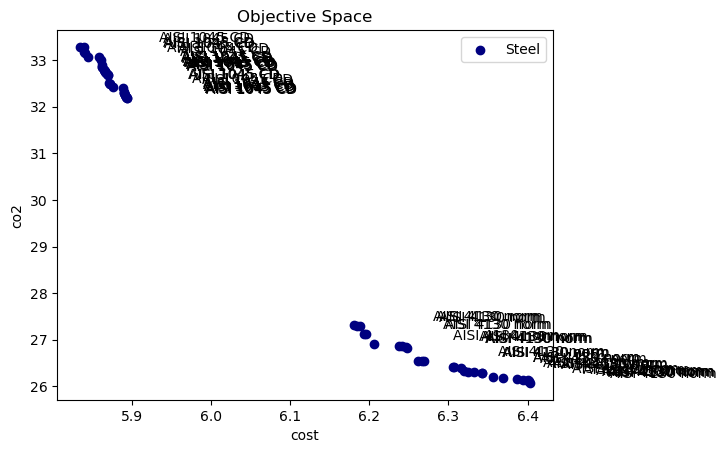

In [99]:
X = res.X
F = res.F
G = res.G

Z_res=X[:,0:2]

names = []
types = []
fig, ax = plt.subplots()
legend_dict = {}


for zData in Z_res:
    dist = np.linalg.norm(zData - z_np, axis=1)
    meanDist = np.max(dist)
    distOrder = np.argsort(dist)
    matname = dataIdentifier['name'][distOrder[0]]
    mattype = dataIdentifier['className'][distOrder[0]]
    names.append(matname)
    types.append(mattype)
    


unique_labels = list(set(types))

mat_colors = {}
for i, mattype in enumerate(types):
    if mattype not in mat_colors:
        mat_colors[mattype] = plt.cm.get_cmap('jet')(i / len(set(types)))

# add scatter plot for each unique label
for i, (x, y) in enumerate(F):
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    ax.scatter(x, y, color=color, label=label)
    ax.text(x + 0.1, y + 0.1, material)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)
    
# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")

# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures/Multi_VAE.png',bbox_inches='tight')
plt.show()

2


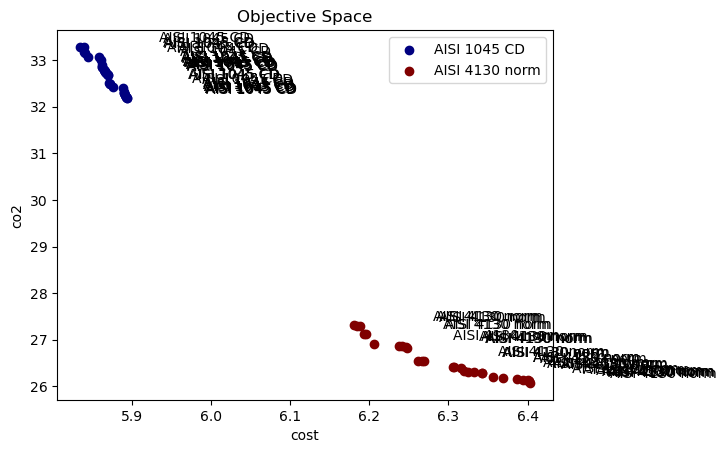

In [100]:
X = res.X
F = res.F
G = res.G

Z_res=X[:,0:2]

names = []
types = []
fig, ax = plt.subplots()
legend_dict = {}


for zData in Z_res:
    dist = np.linalg.norm(zData - z_np, axis=1)
    meanDist = np.max(dist)
    distOrder = np.argsort(dist)
    matname = dataIdentifier['name'][distOrder[0]]
    mattype = dataIdentifier['className'][distOrder[0]]
    names.append(matname)
    types.append(mattype)
    


unique_labels = list(set(names))

mat_colors = {}
for i, matname in enumerate(names):
    if matname not in mat_colors:
        mat_colors[matname] = plt.cm.get_cmap('jet')(i / 10)

print(len(set(names)))
# add scatter plot for each unique label
for i, (x, y) in enumerate(F):
    material = names[i]
    mattype = types[i]
    color = mat_colors[material]
    label = material
    ax.scatter(x, y, color=color, label=label)
    ax.text(x + 0.1, y + 0.1, material)
    if material not in legend_dict:
        legend_dict[material] = ax.scatter(x, y, color=color, label=label)
    
# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")

# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures/Multi_VAE.png',bbox_inches='tight')
plt.show()